## Project: Tracking Solar Power Usage around California

I would like to see the types of Solar Power installations and its accessibility throughout California, as renewable energy is becoming more and more prevalent. By visualizing this data, I aim to find trends and patterns in solar power installations that would help future infrastructure planning, solar energy and/or renewable energy policies, and strategies for increasing renewable energy usage as well.

The data sets I will be using are from the California Open Data Portal:
1. https://data.ca.gov/dataset/solar-footprints-in-california/resource/85b0afc5-f75c-4805-9f8e-7cc98113d244 (solar footprint csv)
2. https://gis.data.ca.gov/datasets/ce721c35ab7e4e4b89ef2080b4c331f6_0/explore?location=36.693449%2C-119.273117%2C5.98 (california counties shape file, taken from California Geo data portal, adjacent to the Open Data Portal)

In [5]:
%matplotlib inline
import os
os.environ["PROJ_LIB"] = r'/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1006/share/proj/'

import numpy as np
import mpl_toolkits
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import json
import folium
import mplleaflet
%matplotlib inline

In [6]:
#initial data to process
ca_counties = gpd.read_file('counties/California_Counties.shp') #use geopandas to read shapefile
print(ca_counties.head(5)) #extract and print the first five entries
solar_footprints = pd.read_csv('Solar_Footprints_V2_5065925295652909767.csv') #tracks california solar power usage + dev

   OBJECTID              NAME  STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  \
0         1    Alameda County  California         06       001  06001   
1         2     Alpine County  California         06       003  06003   
2         3     Amador County  California         06       005  06005   
3         4      Butte County  California         06       007  06007   
4         5  Calaveras County  California         06       009  06009   

     Shape__Are     Shape__Len  \
0  3.084661e+09  448425.775672   
1  3.156006e+09  275565.131463   
2  2.562531e+09  359593.235353   
3  7.340033e+09  525974.550843   
4  4.356209e+09  367005.674344   

                                            geometry  
0  MULTIPOLYGON (((-13602253.477 4536144.556, -13...  
1  POLYGON ((-13347274.736 4711759.133, -13345788...  
2  POLYGON ((-13366983.072 4680058.246, -13366989...  
3  POLYGON ((-13514702.077 4887275.447, -13514730...  
4  POLYGON ((-13366406.546 4651605.021, -13366413...  


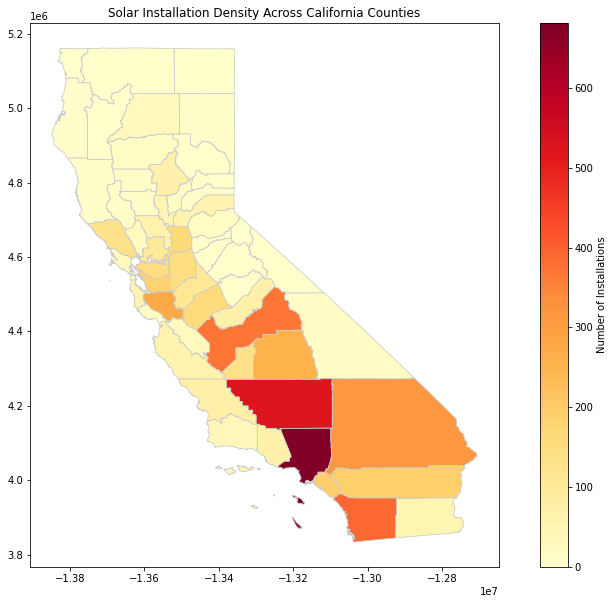

In [7]:
#map install types to numbers to make analysis and plotting easier
install_type_numeric = {
    'Rooftop': 1,
    'Parking': 2,
    'Ground': 3,
    'None' : 4
}
solar_footprints['Install Type Numeric'] = solar_footprints['Install Type'].map(install_type_numeric)

#density of solar installations based on county in california

#isolate counties for solar footprints data
county_counts = solar_footprints['County'].value_counts().reset_index()  #need to reset index according to value counts
county_counts.columns = ['County', 'Installation_Count'] 

count_data = ca_counties.merge(county_counts, left_on='NAME', right_on='County', how='left') #merge geo data with installation data
count_data['Installation_Count'] = count_data['Installation_Count'].fillna(0) #this is to makesure even the counties w/o data show up on the map

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

count_data.plot(column='Installation_Count', ax=ax, legend=True, cmap='YlOrRd', edgecolor='0.8', linewidth=0.8, 
                           legend_kwds={'label': 'Number of Installations'}) #plot count data with a heatmap legend to reference

ax.set_title('Solar Installation Density Across California Counties')

plt.show()

In [8]:
#in regards to solar installations:
install_type_counts = solar_footprints['Install Type'].value_counts()
print("Installation Types:")
print(install_type_counts)

#print largest and smallest solar installations
print(f"The county with the largest amount of solar installations is {county_counts['County'][0]} with {county_counts['Installation_Count'][0]} solar installations")
print(f"The county with the smallest amount of solar installations is {county_counts['County'][(len(county_counts)-1)]} with {county_counts['Installation_Count'][(len(county_counts)-1)]} solar installations")

#split into two sets, one for urban and one for rural
urban_data = solar_footprints[solar_footprints['Urban or Rural'] == 'Urban']
rural_data = solar_footprints[solar_footprints['Urban or Rural'] == 'Rural']

#find acres of land data per county
county_acres = solar_footprints.groupby('County')['Acres'].agg(['count','mean','min', 'max', 'sum'])

print(county_acres.sort_values('sum', ascending=False).head(5)[['sum', 'count']])

print("Average distance to electrical substation, Urban areas is", urban_data['Distance to Substation (Miles) CAISO'].mean())
print("Average distance to electrical substation, Rural areas is", rural_data['Distance to Substation (Miles) CAISO'].mean())

Installation Types:
Ground     2164
Rooftop    1841
Parking    1392
Name: Install Type, dtype: int64
The county with the largest amount of solar installations is Los Angeles County with 681 solar installations
The county with the smallest amount of solar installations is Tuolumne County with 1 solar installations
                                sum  count
County                                    
Kern County            31120.012374    523
Riverside County       27407.234213    189
Imperial County        16433.794820     48
San Bernardino County  16015.421073    317
Kings County           15900.618199    137
Average distance to electrical substation, Urban areas is 5.664370498040919
Average distance to electrical substation, Rural areas is 8.182581278370131


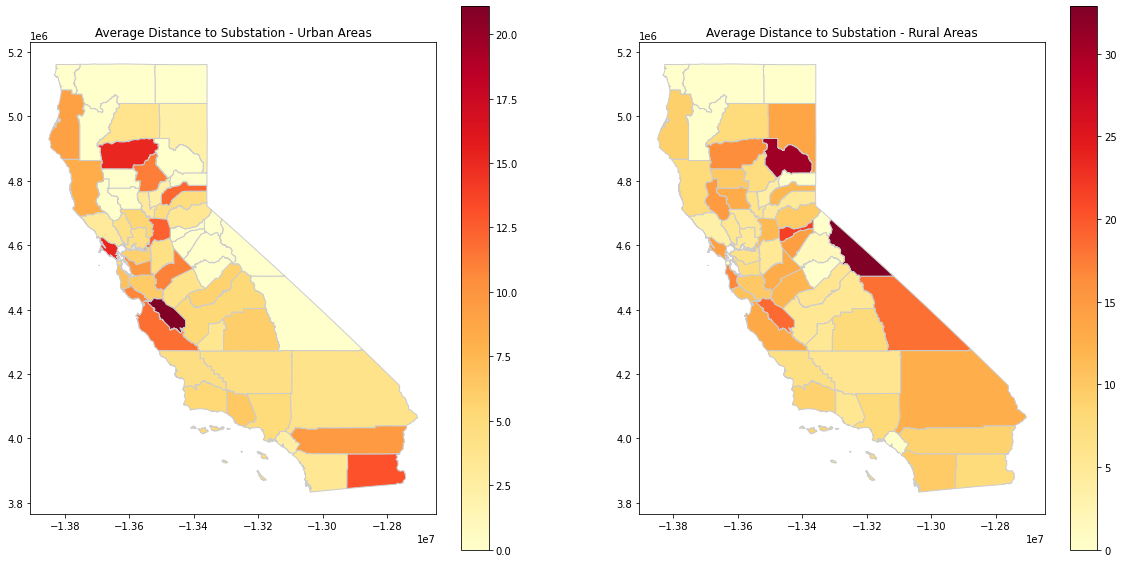

In [9]:
urban_avg = urban_data.groupby('County')['Distance to Substation (Miles) CAISO'].mean() #find the mean distance to each substation per county 
rural_avg = rural_data.groupby('County')['Distance to Substation (Miles) CAISO'].mean()

#merge data with geo data
urban_map = ca_counties.merge(urban_avg, left_on='NAME', right_index=True, how='left')
rural_map = ca_counties.merge(rural_avg, left_on='NAME', right_index=True, how='left')

#fill non existent data with 0 to show up on color map
urban_map['Distance to Substation (Miles) CAISO'] = urban_map['Distance to Substation (Miles) CAISO'].fillna(0)
rural_map['Distance to Substation (Miles) CAISO'] = rural_map['Distance to Substation (Miles) CAISO'].fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

urban_map.plot(column='Distance to Substation (Miles) CAISO', ax=ax1, legend=True, cmap='YlOrRd', edgecolor='0.8')
ax1.set_title('Average Distance to Substation - Urban Areas')

rural_map.plot(column='Distance to Substation (Miles) CAISO', ax=ax2, legend=True, cmap='YlOrRd', edgecolor='0.8')
ax2.set_title('Average Distance to Substation - Rural Areas')

plt.show()

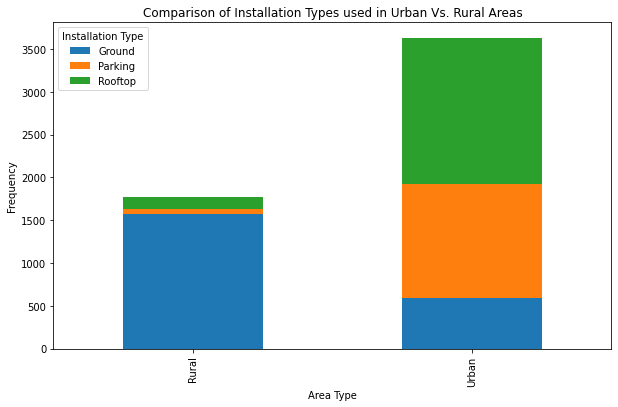

In [10]:
# type of installation crossed with urban or rural
urban_or_rural = solar_footprints.groupby(['Urban or Rural', 'Install Type']).size().unstack() 

#plot stacked bar charts with legend
urban_or_rural.plot(kind='bar', stacked=True, figsize=(10, 6)) 
plt.title('Comparison of Installation Types used in Urban Vs. Rural Areas')
plt.xlabel('Area Type')
plt.ylabel('Frequency')
plt.legend(title='Installation Type', loc='upper left')
plt.show()

In [13]:
install_type_counts = solar_footprints.groupby(['County', 'Install Type']).size().unstack(fill_value=0) 
popular_type = install_type_counts.idxmax(axis=1) #find the max in each county stack 

#create a data frame to isolate the county and most popular installation type to use later
pop_type_counties = pd.DataFrame({
    'County': popular_type.index,
    'Most Popular Type': popular_type.values
})
#merge with geo data
counties_pop = ca_counties.merge(pop_type_counties, left_on='NAME', right_on='County', how='left')

#create a choropleth!
m = folium.Map(location=[37.8, -122], zoom_start=6)

folium.Choropleth(
    geo_data=counties_pop,
    name="choropleth",
    data=solar_footprints,
    columns=["County", "Install Type Numeric"], #using numeric install types 
    key_on="feature.properties.NAME",
    fill_color="YlGn",
    fill_opacity=0.6,
    line_opacity=0.1,
    legend_name="Install Types"
).add_to(m)


title_html = f'''
    <h3 style="
        position: absolute;
        top: 20px;
        left: 20px;
        z-index:100000;
        font-family: Arial;
        font-size: 18px;
        font-weight: bold;
        color: #333333;
        padding: 10px;
        border-radius: 5px;
        max-width: 300px;">
        {"Average Solar Installation Type in Each California County"}
    </h3>'''

m.get_root().html.add_child(folium.Element(title_html))

#style and highlight functions for the interactive pop ups
style_function = lambda x: {
    'fillColor': '#ffffff', 
    'color':'#000000', 
    'fillOpacity': 0.1, 
    'weight': 0.1
}

highlight_function = lambda x: {
    'fillColor': '#000000', 
    'color':'#000000', 
    'fillOpacity': 0.50, 
    'weight': 0.1
}

#create pop ups that portray county + most popular type when hovered over
folium.GeoJson(
    counties_pop,
    style_function=style_function,
    highlight_function=highlight_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME', 'Most Popular Type'],
        aliases=['County:', 'Most Popular Installation Type:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    ),
    popup=folium.GeoJsonPopup(
        fields=['NAME', 'Most Popular Type'],
        aliases=['County:', 'Most Popular Installation Type:'],
        style="background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
    )
).add_to(m)

folium.LayerControl().add_to(m) #add everything to the map

#m